# Grade: 100 points

# Assignment 03: Classification with Decision Trees, Ensemble Models and Neural Networks

## Instructions

Just like assignment 2, you will train various machine learning models for the binary classification task provided in the [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) competition. Note: we will play loosely with the terms validation and test sets and may even use them interchangeably. This Kaggle competition has its own Test set file that you can make predications on and submit for scoring, so for us our "test" set could be viewed as a validation set.

The task is to predict whether an individual would survive the famous disaster. There are 11 input variables, and 2 output labels: **survived** or **did not survive**.

#### **Follow these steps before submitting your assignment:**

1. Complete the notebook.

2. Make sure all plots have axis labels.

3. Once the notebook is complete, `Restart` your kernel by clicking 'Kernel' > 'Restart & Run All'.

4. Fix any errors until your notebook runs without any problems.

5. Please note, a random seed of 42 needs to be set to ensure the reproducability of the results -- *DO NOT* change this random seed. **If you call additional functions that are based on random number generators, you will need to define their seed to 42 as well**.

6. Make sure to reference all external code and documentation used.

*Note: you may need to install XGBoost. You can do this by running the cell below.*

In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn.utils as utils

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Q1 - Data Loading and Exploration

`https://www.kaggle.com/competitions/titanic` contains data on passengers of the famous Titanic disaster. The task is to examine and predict what sorts of people were more likely to survive using data on their name, age, gender, socio-economic class, etc.

#### 1. Loading our Data
Load the train data into a pandas DataFrames. Display the first few rows **of each DataFrame** and print the shape of the dataframe.

In [3]:
#Q1.1
# Load the Titanic training dataset
train = pd.read_csv("train.csv")

#### 2. Checking for Null Values

Check for null values in the training data.

In [4]:
#Q1.2
# Check for null values in the training dataset
print("Number of missing values in each column:")
print(train.isnull().sum())


Number of missing values in each column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


#### 3. Checking the class balance
Since this is a binary classification task, class balance is extremely important. What percent of the training data belongs to each class? Is this roughly balanced?

In [5]:
#Q1.3
# Calculate class percentages
class_percent = train['Survived'].value_counts(normalize=True) * 100

print("Class distribution (%):")
print(class_percent)



Class distribution (%):
Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64


You should see that the classes are roughly balanced, about a 60-40 split between not surviving and surviving.

# Q2 - Feature Engineering

1. Fill missing values for Age and Fare with their respective median values, make sure to round age.

In [6]:
#Q2.1
# Fill missing Age with median and round
train['Age'] = train['Age'].fillna(train['Age'].median()).round().astype(int)

# Fill missing Fare with median
train['Fare'] = train['Fare'].fillna(train['Fare'].median())


2. Drop non-unique variables such as `PassengerId`, and irrelevant features such as `Ticket`, `Cabin`, and `Embarked`.

In [7]:
#Q2.2
cols_to_drop = ['PassengerId', 'Ticket', 'Cabin', 'Embarked']
train = train.drop(columns=cols_to_drop)


3. Combine `SibSp` and `Parch` into a single variable `Family`. Then drop `SibSp` and `Parch`.

In [8]:
#Q2.3
# Create Family feature
train['Family'] = train['SibSp'] + train['Parch']

# Drop SibSp and Parch
train = train.drop(columns=['SibSp', 'Parch'])


Like Assignment 2, the `Name` column contains passengers' full names, including their titles (e.g., Mr., Mrs., Dr., Col.). Write code to **extract only the title** from each passenger's name. Standardize similar titles (e.g., Ms --> Miss, Mlle --> Miss, Mme --> Mrs), and group rare or honorific titles (e.g., Capt, Col, Dr, Sir, etc.) under a single label called "Special".

In [9]:
special_names = ['Capt','Col','Countess','Don','Dona','Dr','Jonkheer','Lady','Major','Rev','Sir']
train['Name'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train['Name'] = train['Name'].replace('Ms', 'Miss').replace('Mlle', 'Miss').replace('Mme', 'Mrs').replace(special_names, 'Special')

4. One-hot-encode the features `Name`, `Sex`, and `Pclass`.

In [10]:
#Q2.4
# One-hot-encode Name, Sex, and Pclass
train = pd.get_dummies(
    train,
    columns=['Name', 'Sex', 'Pclass'],
    drop_first=True
)

5. Correlation Map
Visualize the correlation between variables using a heatmap. List the 3 features that are most related to a passenger's survival.

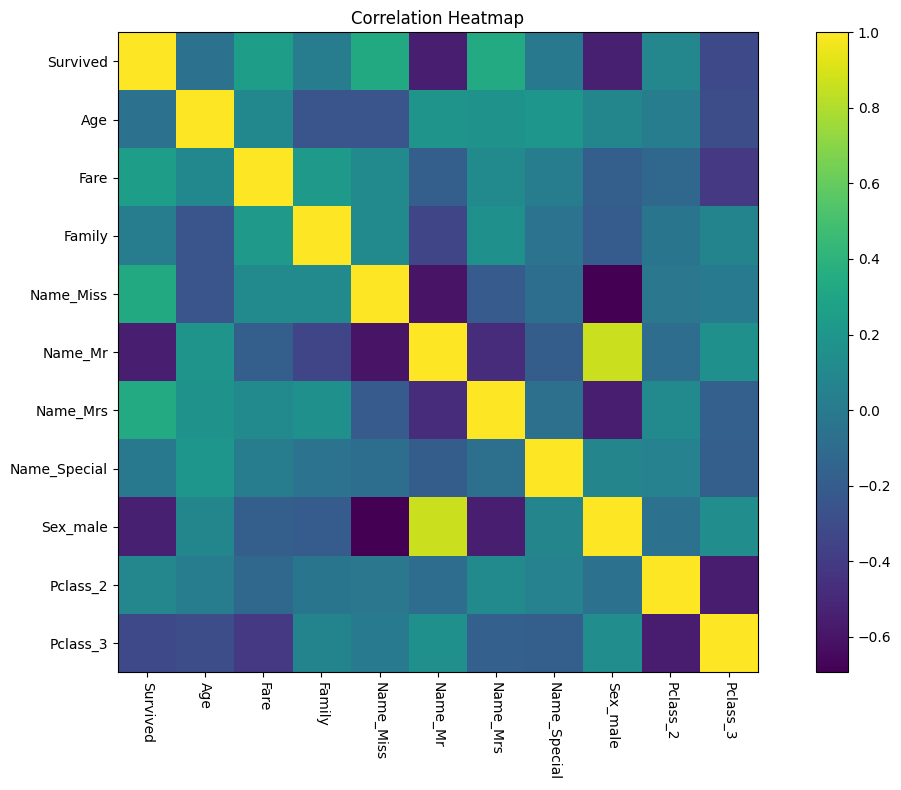

In [11]:
#Q2.5 Correlation Map
# Compute correlation matrix
corr = train.corr()

# Plot heatmap using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(corr, interpolation='nearest')
plt.title("Correlation Heatmap")
plt.colorbar()

# Add feature labels
ticks = np.arange(len(corr.columns))
plt.xticks(ticks, corr.columns, rotation=270)
plt.yticks(ticks, corr.columns)

plt.tight_layout()
plt.show()

In [12]:
#Q2.5 List of three features
# Get correlations with Survived
surv_corr = corr['Survived'].abs().sort_values(ascending=False)

# Drop the survival=1 correlation
top3 = surv_corr.iloc[1:4]
print(top3)

Name_Mr     0.549199
Sex_male    0.543351
Name_Mrs    0.341994
Name: Survived, dtype: float64


### Checkpoint 1

![Checkpoint 1](checkpoint_1.png)

Your `train.head()` should look like this.

In [13]:
train.head()

,Survived,Age,Fare,Family,Name_Miss,Name_Mr,Name_Mrs,Name_Special,Sex_male,Pclass_2,Pclass_3
0,0,22,7.2500,1,False,True,False,False,True,False,True
1,1,38,71.2833,1,False,False,True,False,False,False,False
2,1,26,7.9250,0,True,False,False,False,False,False,True
3,1,35,53.1000,1,False,False,True,False,False,False,False
4,0,35,8.0500,0,False,True,False,False,True,False,True


# Q3 - Train/Test Split and Feature Scaling

#### 1. Scaling
Scale the train. Make sure you do not scale the one-hot-encoded data or the target variable (Survived).

In [14]:
train.dtypes

Survived          int64
Age               int32
Fare            float64
Family            int64
Name_Miss          bool
Name_Mr            bool
Name_Mrs           bool
Name_Special       bool
Sex_male           bool
Pclass_2           bool
Pclass_3           bool
dtype: object

In [15]:
#Q3.1
# Identify columns to scale (numerical only, excluding Survived)
num_cols = ['Age', 'Fare', 'Family']  # these are the numeric features

# Initialize scaler
scaler = StandardScaler()

# Fit and transform numeric columns
train[num_cols] = scaler.fit_transform(train[num_cols])

# Check first few rows to confirm scaling
print(train.head())

   Survived       Age      Fare    Family  Name_Miss  Name_Mr  Name_Mrs  \
0         0 -0.565459 -0.502445  0.059160      False     True     False   
1         1  0.664317  0.786845  0.059160      False    False      True   
2         1 -0.258015 -0.488854 -0.560975       True    False     False   
3         1  0.433734  0.420730  0.059160      False    False      True   
4         0  0.433734 -0.486337 -0.560975      False     True     False   

   Name_Special  Sex_male  Pclass_2  Pclass_3  
0         False      True     False      True  
1         False     False     False     False  
2         False     False     False      True  
3         False     False     False     False  
4         False      True     False      True  


Drop the target from the training data and add it to its own dataframe

In [16]:
target = train['Survived']
train.drop(['Survived'], axis=1, inplace=True)

#### 2. Train/Test Split
Split the training data into a train and test set using an 80-20 split. Make sure you preserve the balance of the target variable using the `stratify = target` argument.

In [17]:
# Split into train and test sets (80-20), stratifying by the target
X_train, X_test, y_train, y_test = train_test_split(
    train,            # features
    target,           # target variable
    test_size=0.2,
    random_state=seed,
    stratify=target   # preserve class balance
)

#### 3. Check the class balance of the train and test set.
Print the percent of samples that survived in both the train and test set. They should be almost equal since you stratified by the target variable when splitting the data.

In [18]:
#Q3.3
# Percent of samples that survived in the training set
train_survived_pct = y_train.value_counts(normalize=True) * 100
print("Train set class distribution (%):")
print(train_survived_pct)

# Percent of samples that survived in the test set
test_survived_pct = y_test.value_counts(normalize=True) * 100
print("\nTest set class distribution (%):")
print(test_survived_pct)

Train set class distribution (%):
Survived
0    61.657303
1    38.342697
Name: proportion, dtype: float64

Test set class distribution (%):
Survived
0    61.452514
1    38.547486
Name: proportion, dtype: float64


# Q4 - Decision Tree Training

Decision trees have a number of parameters to adjust. For this assignment we have chosen `criterion`, `max_depth`, `max_features`, and `splitter` as the parameters to adjust. You will exhaustively search over some values of these parameters using a grid search.

The grid and potential parameter values are defined below. For more information on what these parameters do, see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [19]:
# Hyper parameters for grid search
param_grid = {'criterion' : ['gini', 'entropy'] # The function to measure the quality of a split.
              , 'max_depth' : [1, 2, 3, 4, 5, None] # None means the tree can grow arbitrarily deep.
              , 'max_features' : [2, 3, 4, 'sqrt', 'log2', None] # The number of features to consider when looking for the best split.
              , 'splitter' : ['best', 'random'] # The strategy used to choose the split at each node.
             }

#### 1. Instantiate a `DecisionTreeClassifier` model.

In [20]:
#Q4.1
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(random_state=seed)

#### 2. Conduct the grid search.

Fit the grid search object on the training data and print the best cross-validation score and best parameters. Use the same parameters for the grid search as in lab 6 for results consistent with mine.

In [21]:
#Q4.2
# Set up GridSearchCV
grid = GridSearchCV(
    estimator=model_tree,
    scoring='accuracy',
    cv=3,
    param_grid=param_grid,
    n_jobs=-1
)          

# Fit on the training data
grid.fit(X_train, y_train)

# Print the best score and parameters
print("Best cross-validation score: {:.4f}".format(grid.best_score_))
print("Best parameters:", grid.best_params_)

Best cross-validation score: 0.8315
Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'splitter': 'best'}


#### 3. Evaluate on the validation set.
Using the best parameters, evaluate the model on the validation set. Calculate the accuracy and AUC on the validation set.

In [22]:
#Q4.3
model_tree = grid.best_estimator_
y_val_pred = model_tree.predict(X_test)

acc_dt = accuracy_score(y_test, y_val_pred)
auc_dt = roc_auc_score(y_test, y_val_pred)

print(f'Accuracy for Decision Tree: {acc_dt:.2%}')
print(f'AUC for Decision Tree: {auc_dt:.2f}')

Accuracy for Decision Tree: 83.80%
AUC for Decision Tree: 0.82


### Checkpoint 2

Your accuracy for this decision tree should be between ~70-83%. It it not controlled via a random seed so results will vary!

# Q5 - Ensemble Models

As we saw in lecture, a single decision tree can be unstable. We can use ensemble models to get more accurate predictions. You will train an XGBoost model which combines multiple trees to see if you can get a better performance. As with decision trees, there are a number of tunable parameters, so you will use a grid search to find the "best" ones.

In [23]:
param_grid = {
    'n_estimators': [100, 200, 300],        # number of boosting rounds
    'max_depth': [3, 4, 5, 6],              # depth of each tree
    'learning_rate': [0.01, 0.05, 0.1],     # step size shrinkage
    'subsample': [0.8, 1.0],                # fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],         # fraction of features used per tree
    'gamma': [0, 0.5, 1],                   # minimum loss reduction to make a split
    'reg_lambda': [1, 5, 10]                # L2 regularization strength
}

#### 1. Instantiate an XGBoost model.

Use the same parameters for the grid search as in lab 6 for results consistent with mine.

In [24]:
xgb = XGBClassifier(random_state = seed, use_label_encoder=False, eval_metric='logloss')
#Q5.1
grid = GridSearchCV(
    estimator=xgb,
    scoring='accuracy',
    cv=3,
    param_grid=param_grid,
    n_jobs=-1
)

#### 2. Conduct the grid search.

Fit the grid search object on the training data and print the best cross-validation score and best parameters.

In [25]:
#Q5.2
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)


0.838492358968904
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 1, 'subsample': 0.8}


C:\Users\minht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [01:15:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### 3. Evaluate on the validation set.
Using the best parameters, evaluate the model on the validation (test) set. Calculate the accuracy and AUC score on the validation set.

In [26]:
#Q5.3
xgb = grid.best_estimator_
y_val_pred = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_val_pred)
auc_xgb = roc_auc_score(y_test, y_val_pred)

print(f'Accuracy for XGBoost: {acc_xgb:.2%}')
print(f'AUC for XGBoost: {auc_xgb:.2f}')



Accuracy for XGBoost: 83.24%
AUC for XGBoost: 0.81


### Checkpoint 3

Your XGboost model should be 83.24% accuracy with and AUC of 0.81. This is controlled by a random seed. If you do not get this value but are close, that is fine too.

# Q6 - Training a Neural Network

The last model you will train is a Neural Network. The Neural Network (NN) architecture will consist of 4 layers:
1. Input (size = 8)
2. Hidden1 (size = 16)
3. Hidden2 (size = 16)
4. Output layer (size = 2)

This is a simple network that uses Relu activation function on each of the hidden layers, and a Sigmoid function on the output.

You will train your model using Binary Cross Entropy Loss for 50 epochs, with an Adam optimizer.

#### 1. Define the NN architecture.

Complete the code below to define the NN architecture. You should have 4 layers, with activation functions between each layer.
1. Input layer (linear)
2. Apply ReLU
3. First hidden layer (linear)
4. Apply Relu
5. Second hidden layer (linear)
6. Apply Sigmoid

Do not edit the `forward` function. The code you write should work without having to edit it.

In [27]:
class Model(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        #Q6.1
        super(Model, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden1_size)   
        self.fc2 = nn.Linear(hidden1_size, hidden2_size) 
        self.fc3 = nn.Linear(hidden2_size, output_size)  
        
        # Define activations
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

#### 2. Prepare the data for training.

Create tensor datasets from `X_train` and `y_train` and from `X_test` and `y_test`. To do this, first convert them to Pytorch tensors. Then turn these into DataLoaders with a batch size of 64. Make sure you shuffle the train loader but do not shuffle the test loader.

In [28]:
# Convert your data to tensors
#Q6.2 Create tensor datasets

# Convert train features and labels to tensors
X_train_tensor = torch.tensor(X_train.astype(float).values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.astype(float).values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [29]:
#Q6.2 Define Dataloaders, you can combine these two steps into a single cell if you'd like.
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### 4. Prepare for training

1. Before instantiating your model, you will need to specify the size of each layer.
2. Instantiate your model.
3. Define your criterion, this if your loss function (remember we are doing binary classification).
4. Declare your optimizer, use `optim.Adam` for this with a learning rate of `0.001`.

In [30]:
#Q6.4 1-4.
# 1. Specify layer sizes
input_size = X_train.shape[1]     # Should be 8 features after preprocessing
hidden1_size = 16
hidden2_size = 16
output_size = 1

# 2. Instantiate your model
model = Model(input_size, hidden1_size, hidden2_size, output_size)

# 3. Define the loss function (Binary Cross Entropy)
criterion = nn.BCELoss()

# 4. Declare the optimizer (Adam, lr = 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### 5. Train your NN

Use the training loop below to train your neural network. The loop keeps track of the training loss and accuracy so we can track their progress and plot them in the next question. There is no coding for you to do here!

In [31]:
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, test_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad() # Zero out the gradients
        outputs = model(xb).squeeze(1) # Get the predictions
        loss = criterion(outputs, yb) # Calculate the loss
        loss.backward() # Backpropagation
        optimizer.step() # Optimize
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb).squeeze(1)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    auc = roc_auc_score(all_labels, all_preds)
    preds_binary = (torch.tensor(all_preds) > 0.5).float()
    acc = accuracy_score(all_labels, preds_binary)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {auc:.4f} | Acc: {acc:.4f}")

Epoch [1/50] | Train Loss: 0.6811 | Val Loss: 0.6743 | AUC: 0.6493 | Acc: 0.6425
Epoch [11/50] | Train Loss: 0.5236 | Val Loss: 0.5040 | AUC: 0.8568 | Acc: 0.7933
Epoch [21/50] | Train Loss: 0.4322 | Val Loss: 0.4383 | AUC: 0.8628 | Acc: 0.8156
Epoch [31/50] | Train Loss: 0.3926 | Val Loss: 0.4300 | AUC: 0.8692 | Acc: 0.8101
Epoch [41/50] | Train Loss: 0.3940 | Val Loss: 0.4292 | AUC: 0.8688 | Acc: 0.8156


#### 6. Plot the training loss and accuracy

Create a plot for the train and test (validation) loss over the epochs.

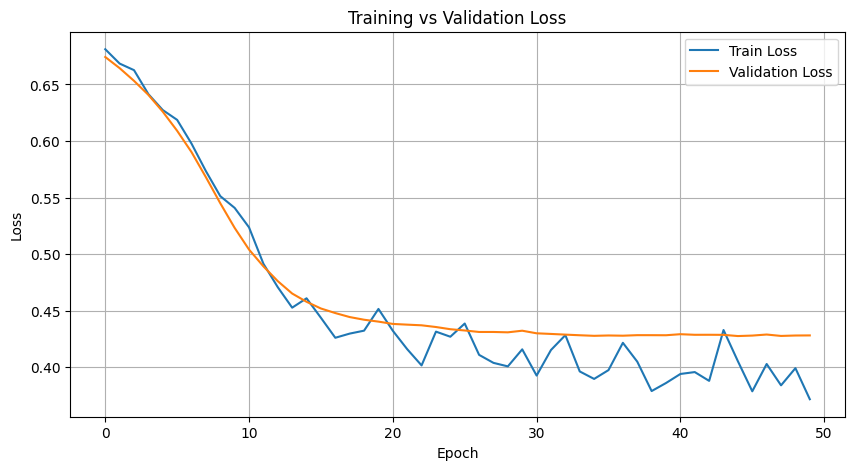

In [32]:
#Q6.6
plt.figure(figsize=(10,5))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

#### 7. Final Evaluation on the Test Set

Use the code below to calculate the test accuracy and AUC score. Again, no code for you to add here!

In [33]:
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

all_preds = []   # for AUC (raw sigmoid outputs)
all_labels = []  # true labels

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch).squeeze()  # sigmoid probabilities
        loss = criterion(outputs, y_batch)

        test_loss += loss.item() * X_batch.size(0)

        # Store for AUC
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

        # Accuracy (thresholded at 0.5)
        preds = (outputs >= 0.5).float()
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)

# Compute averages
avg_test_loss = test_loss / test_total
acc_nn = test_correct / test_total

# Compute AUC
auc_nn = roc_auc_score(all_labels, all_preds)

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {acc_nn:.4f}")
print(f"Test AUC: {auc_nn:.4f}")


Test Loss: 0.4307
Test Accuracy: 0.8156
Test AUC: 0.8664


# Q7 - Model Evaluation & Comparison

#### 1. Accuracy and AUC Comparison
Display the accuracy and AUC of each model in a table using the `display()` function.

In [34]:
#Q7.1
# Create a dictionary with model names and their metrics
results = {
    "Model": [
        "Decision Tree",
        "XGBoost",
        "Neural Network"
    ],
    "Accuracy": [
        acc_dt,
        acc_xgb,
        acc_nn
    ],
    "AUC": [
        auc_dt,
        auc_xgb,
        auc_nn
    ]
}

results_df = pd.DataFrame(results)
display(results_df)

,Model,Accuracy,AUC
0,Decision Tree,0.837989,0.824967
1,XGBoost,0.832402,0.809618
2,Neural Network,0.815642,0.866403


#### Discussion

State which model performed best. If you wanted to attempt to improve performance of any of these models' performance what would you try and what is the reasoning behind your decision?

Discussion answer here.

Although the Neural Network achieved the highest AUC (0.866), the Decision Tree and XGBoost had slightly higher accuracy (0.838 and 0.832, respectively). This suggests that while the Neural Network is better at ranking passengers by survival probability (AUC), the tree-based models make slightly more correct classifications overall. Performance could potentially be improved through feature engineering, hyperparameter tuning, or ensemble methods to better capture patterns, optimize learning, and reduce variance.